21.02.2024

In [195]:
import pandas as pd 
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics 
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings("ignore")

In [32]:
df_2023 = pd.read_excel('full_dfs/df_2023_full.xlsx')
df_2021 = pd.read_excel('full_dfs/df_2021_full.xlsx')
df_2020 = pd.read_excel('full_dfs/df_2020_full.xlsx')
df_2019 = pd.read_excel('full_dfs/df_2019_full.xlsx')
df_bank_ids = pd.read_excel('full_dfs/bank_ids.xlsx')

roa_2016 = pd.read_excel('full_dfs/roa_2016.xlsx')
roa_2017 = pd.read_excel('full_dfs/roa_2017.xlsx')
roa_2018 = pd.read_excel('full_dfs/roa_2018.xlsx')

In [30]:
# типовая ссылка на карточку банка
url = f'https://www.banki.ru/banks/ratings/?BANK_ID=322&IS_SHOW_GROUP=0&IS_SHOW_LIABILITIES=0&date1=2021-12-01&date2=2021-01-01'    

# Собираем осмысленные переменные

- На смартлабе есть некоторые показатели за 2022 и 2023, но там только для банков, торгующихся на бирже https://smart-lab.ru/q/SBER/f/y/

### Banks’ risk clustering using k-means: a method based on size and individual & systemic risks
https://drive.google.com/file/d/1FM3AV05f2CrFG5oDe0lKZ3H9cftbDheo/view

The factor called __RatioBS__ measures banks’ exposures using balance sheet ratios, such as: 
- ??? `debt / total assets` <br>
__debt__ = long term borrowings (*Кредиты сроком более 1 года ЮЛ + ФЛ*) + short term borrowings (*Кредиты сроком до 1 года ЮЛ + ФЛ*) + securities sold with repurchase agreements (*Бумаги переданные в РЕПО*). <br>
total assets = *Активы нетто*
- `deposit / total assets` <br>
__deposit__ = total deposits received from customers (*ФЛ Счета + ЮЛ Счета?*)
- `total loans / total assets` - It shows to what extent a bank is engaged in non-classical banking activities. If the value is low, then a bank has a high interbank or trading exposure.<br> 
total loans = *Кредиты физическим лицам + Кредиты предприятиям и организациям + Выданные МБК*. 
- `total loans / deposit` - LDR <br>
LDR > 1 => банк выдает больше кредитов, чем получает в виде депозитов от клиентов. Это может указывать на то, что банк дополнительно финансирует свои кредитные операции через другие источники, такие как межбанковское кредитование или выпуск облигаций.<br>
LDR < 1 => банк получает больше депозитов, чем выдает в виде кредитов. Это может указывать на более консервативную стратегию финансирования и уровень ликвидности банка.
- `non-performing assets / total assets` <br> 
__Non-performing assets__ are composed of non-accrual loans, restructured loans and foreclosed real estate <br>
non-performing assets 
- `non-performing-loans / total loans` <br>
 __non-performing-loans__ =  those in default or close to default. (просрочка) *ФЛ Просроченная задолженность* + *ЮЛ Просроченная задолженность*
- `reserve for loan loss / total loans` 

The __CreditBS__ factor assesses banks’ credit worthiness based on balance
sheet information, such as:
- `common equity / total assets` 
- `ROA` 
- `price / book ratio` = bank’s market capitalization / its common equity.
- `Texas ratio` = bank’s non-performing assets / (reserve for loan loss + total equity). total equity = Капитал по форме 123
- `Z-score` Simple and popular risk measure of a bank’s probability of insolvency.


We also build the __RegCapital__ factor highlighting the main Basel’s capital ratios:
- Tier 1 capital ratio, 
- total risk-based capital ratio, capital adequacy ratio (CAR)
- risk-weighted-asset / total assets. 


### __Украинская статья__ <br>
- `retail loans / revenue generating assets` - A high value of this variable evidences that a bank serves individuals mainly. If the value is low, a bank orients more on
the corporate or wholesale market
- `retail funding / overal liabilities - subordinate debt` - it shows to what extent a bank relies on individuals to fund its operations

- Средняя ставка по кредитам ?
- Средняя ставка по депозитам ?
- Разница между ними ?

credit risk:
- `NPL ratio` - колонка Уровень просроченной задолженности по кредитному портфелю
- `NPL coverage` - колонка Уровень резервирования по кредитному портфелю


### __Using clustering ensemble to identify banking business models__
Делят все показатели на total assets, а сами total assets логарифмируют
- Кредиты предприятиям и организациям / Активы нетто
- Кредиты физическим лицам / Активы нетто
- Выданные МБК / Активы нетто
- (ФЛ Счета + ЮЛ Счета) / Активы нетто
- Привлеченные МБК / Активы нетто
- log(Активы нетто)
- Капитал (по форме 123) / Активы нетто

### Переменные риска

Работа 2 (Иранские банки)<br>

- Показатель LADD - риск ликвидности. Вместо него в нашей работе 2 показателя __H2__ и __H3__ <br>
(LADD = - (Liquidity Asset) / Demand deposit)

- Z-score. __H1__ - минимальная величина собственных средств (капитала) банка, необходимых для покрытия кредитного и рыночного рисков  = total equities / total assets ?<br>
![](https://i.imgur.com/4NpU0FR.png) 
Чем меньше Z-score, тем рискованнее банк


In [17]:
# нужные данные для Z-score

df_roa_2016 = df_2021[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2016'})
df_roa_2017 = df_2021[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2017'})
df_roa_2018 = df_2021[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2018'})
df_roa_2019 = df_2019[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2019'})
df_roa_2020 = df_2020[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2020'})
df_roa_2021 = df_2021[['bank_name', 'Рентабельность активов-нетто']].rename(columns = {'Рентабельность активов-нетто' : 'ROA_2021'})

df_stdev_roas = df_roa_2021.merge(
    df_roa_2020, how='left', on='bank_name').merge(
        df_roa_2019, how='left', on='bank_name').merge(
            df_roa_2018, how='left', on='bank_name').merge(
                df_roa_2017, how='left', on='bank_name').merge(
                    df_roa_2016, how='left', on='bank_name')

df_stdev_roas['std_ROA_2019'] = df_stdev_roas[['ROA_2019', 'ROA_2018', 'ROA_2017', 'ROA_2016']].std(axis=1)
df_stdev_roas['std_ROA_2020'] = df_stdev_roas[['ROA_2020', 'ROA_2019', 'ROA_2018', 'ROA_2017']].std(axis=1)
df_stdev_roas['std_ROA_2021'] = df_stdev_roas[['ROA_2021', 'ROA_2020', 'ROA_2019', 'ROA_2018']].std(axis=1)

In [22]:
df_stdev_roas.head()

,bank_name,ROA_2021,ROA_2020,ROA_2019,ROA_2018,ROA_2017,ROA_2016,std_ROA_2019,std_ROA_2020,std_ROA_2021
0,Сбербанк,3.50,2.49,3.10,3.50,3.50,3.50,0.200,0.477170,0.477170
1,ВТБ,1.43,0.37,1.30,1.43,1.43,1.43,0.065,0.512014,0.512014
2,Газпромбанк,1.68,0.44,0.99,1.68,1.68,1.68,0.345,0.600687,0.600687
3,Альфа-Банк,2.71,4.20,1.90,2.71,2.71,2.71,0.405,0.959271,0.959271
4,Московский кредитный банк (МКБ),0.90,0.45,2.19,0.90,0.90,0.90,0.645,0.750600,0.750600


# Собираем фичи

## 2019

In [24]:
df_2019.columns

Index(['bank_name', 'Вложения в ценные бумаги', 'Кредитный портфель',
       'Просроченная задолженность в кредитном портфеле', 'Активы нетто',
       'Бумаги переданные в РЕПО', 'Векселя', 'Вклады физических лиц',
       'Вклады физических лиц оборот', 'Вложения в акции',
       'Вложения в векселя', 'Вложения в капиталы других организаций',
       'Вложения в облигации', 'Выданные МБК', 'Выданные МБК оборот всего',
       'Выпущенные облигации и векселя', 'Высоколиквидные активы',
       'Денежные средства в кассе', 'Денежные средства в кассе оборот',
       'Капитал (по форме 123)', 'КрФЛ Сроком более 3 лет',
       'КрФЛ Сроком до 180 дней', 'КрФЛ Сроком от 1 года до 3 лет',
       'КрФЛ Сроком от 181 дня до 1 года', 'КрЮЛ Сроком более 3 лет',
       'КрЮЛ Сроком до 180 дней', 'КрЮЛ Сроком от 1 года до 3 лет',
       'КрЮЛ Сроком от 181 дня до 1 года',
       'Кредиты предприятиям и организациям', 'Кредиты физическим лицам',
       'ЛОРО-счета', 'НОСТРО-счета', 'Облигации', 'Овердр

In [33]:
df_2019['Deposits/TotalAssets'] = (df_2019['ФЛ Счета'] + df_2019['ЮЛ Счета']) / df_2019['Активы нетто']

df_2019['TotalLoans/TotalAssets'] = (df_2019['Кредиты предприятиям и организациям'] 
                                     + df_2019['Кредиты физическим лицам']
                                     + df_2019['Выданные МБК']) / df_2019['Активы нетто']

df_2019['TotalLoans/Deposits'] = ((df_2019['Кредиты предприятиям и организациям'] 
                                     + df_2019['Кредиты физическим лицам']
                                     + df_2019['Выданные МБК']) / (df_2019['ФЛ Счета'] 
                                                                               + df_2019['ЮЛ Счета']))

df_2019['NPL/TotalLoans'] = ((df_2019['ФЛ Просроченная задолженность'] 
                             + df_2019['ЮЛ Просроченная задолженность']) / (df_2019['Кредиты предприятиям и организациям'] 
                                                                            + df_2019['Кредиты физическим лицам']
                                                                            + df_2019['Выданные МБК']))

df_2019 = df_2019.merge(df_stdev_roas[['bank_name', 'std_ROA_2019']], how='left', on='bank_name')
df_2019['Z-score'] = (df_2019['Рентабельность активов-нетто'] + df_2019['Н1'])/df_2019['std_ROA_2019']

In [36]:
df_2019 = df_2019.rename(columns = {'Рентабельность активов-нетто' : 'ROA',
                          'Рентабельность капитала' : 'ROE', 
                          'Уровень просроченной задолженности по кредитному портфелю' : 'NPL Ratio',
                          'Уровень резервирования по кредитному портфелю' : 'NPL Coverage', 
                          'Н2' : 'Н2 liquidity',
                          'Н3' : 'Н3 liquidity',
                          'Активы нетто': 'Total Assets',
                          'Капитал (по форме 123)' : 'Капитал',
                          'Уровень обеспечения кредитного портфеля залогом имущества' : 'LTV',
                          'Н1' : 'Н1 CAR'})

In [38]:
df_2019['КредитыЮЛ/TotalAssets'] = df_2019['Кредиты предприятиям и организациям'] / df_2019['Total Assets']
df_2019['КредитыФЛ/TotalAssets'] = df_2019['Кредиты физическим лицам'] / df_2019['Total Assets']
df_2019['ВыданныеМБК/TotalAssets'] = df_2019['Выданные МБК'] / df_2019['Total Assets']
df_2019['ПривлеченныеМБК/TotalAssets'] = df_2019['Привлеченные МБК'] / df_2019['Total Assets']
df_2019['log_TotalAssets'] = np.log1p(df_2019['Total Assets'])
df_2019['Капитал/Активы'] = df_2019['Капитал'] / df_2019['Total Assets']

In [42]:
X = df_2019[['Н1 CAR','Н2 liquidity', 'Н3 liquidity', 'ROA', 'ROE', 'LTV', 'NPL Ratio',
       'NPL Coverage', 'Deposits/TotalAssets', 'TotalLoans/TotalAssets',
       'TotalLoans/Deposits', 'NPL/TotalLoans', 'Z-score',
       'КредитыЮЛ/TotalAssets', 'КредитыФЛ/TotalAssets',
       'ВыданныеМБК/TotalAssets', 'ПривлеченныеМБК/TotalAssets',
       'log_TotalAssets', 'Капитал/Активы']]

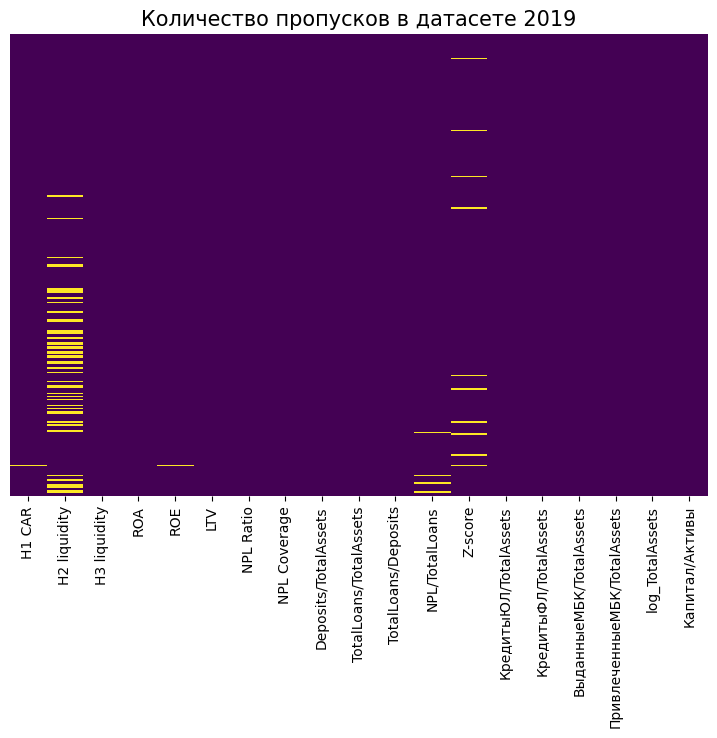

In [45]:
fig, ax = plt.subplots(figsize=(9,6))
ax.set_title('Количество пропусков в датасете 2019', fontsize=15)
sns_heatmap = sns.heatmap(X.isnull(), 
                          yticklabels=False, 
                          cbar=False, 
                          cmap='viridis')

Ленивый способ - заменим пропуски на среднее. По хорошему надо KNN-ом их заполнить

In [57]:
# делим на 0 - получаются бесконечности - заменим их на 0 
X.loc[X['TotalLoans/Deposits'] == np.inf, 'TotalLoans/Deposits'] = np.nan
X.loc[X['Z-score'] == np.inf, 'Z-score'] = np.nan

In [75]:
numeric_means = X.mean()
X = X.fillna(numeric_means)

## EDA

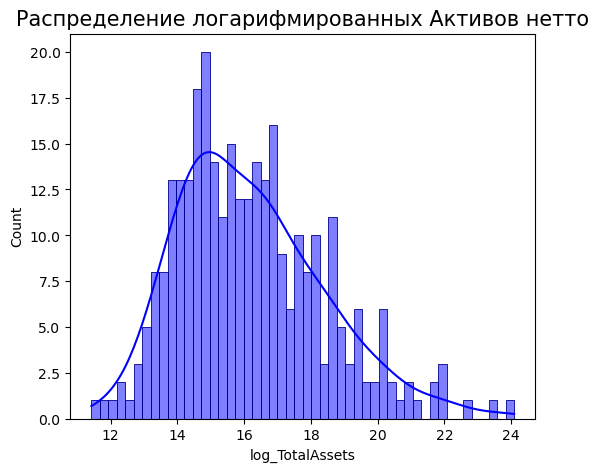

In [64]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_title('Распределение логарифмированных Активов нетто', fontsize=15)
sns.histplot(X['log_TotalAssets'],
             bins=50,
             ax=ax,
             color='blue',
             edgecolor='darkblue',
             kde = True);

In [65]:
print('Наибольшее кол-во TA лежит в интервале:', np.exp(13), '-',np.exp(17))
print('Среднее значение цены',X['log_TotalAssets'].mean())

Наибольшее кол-во TA лежит в интервале: 442413.3920089205 - 24154952.7535753
Среднее значение цены 16.196801497416637


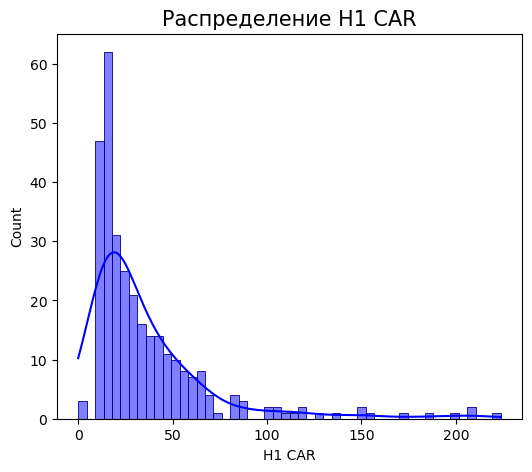

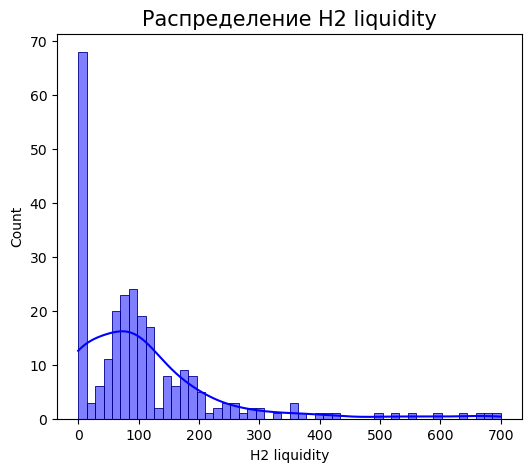

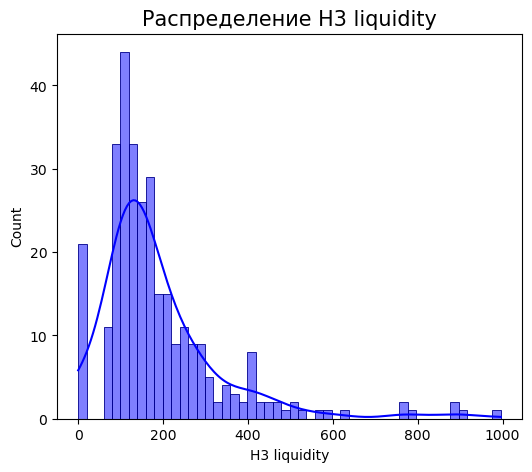

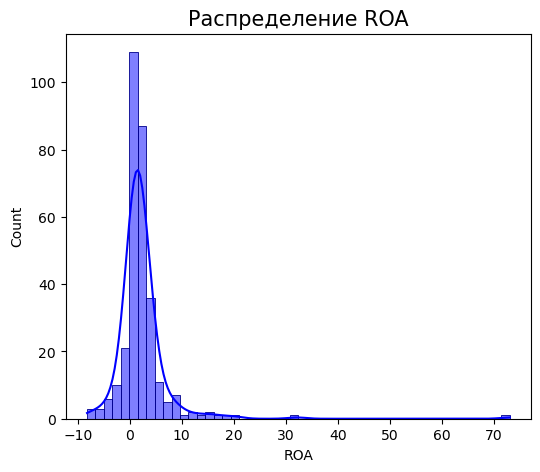

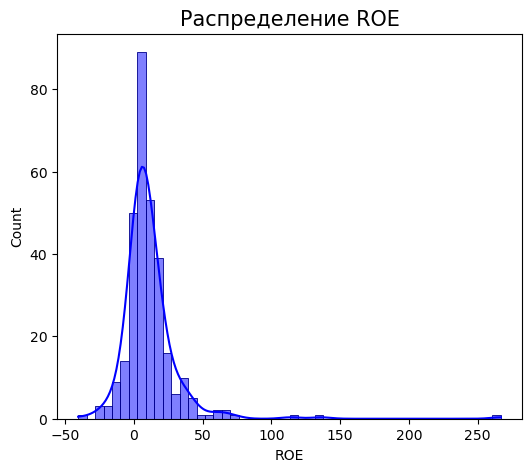

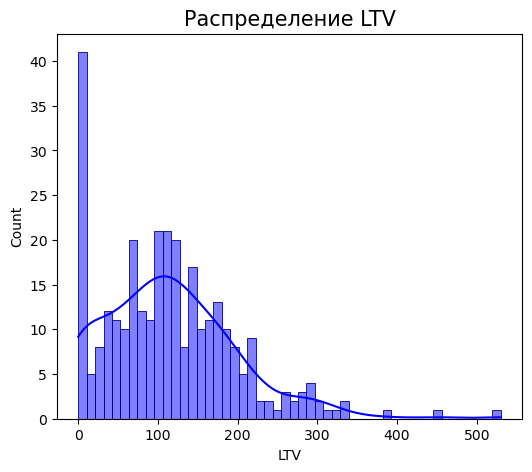

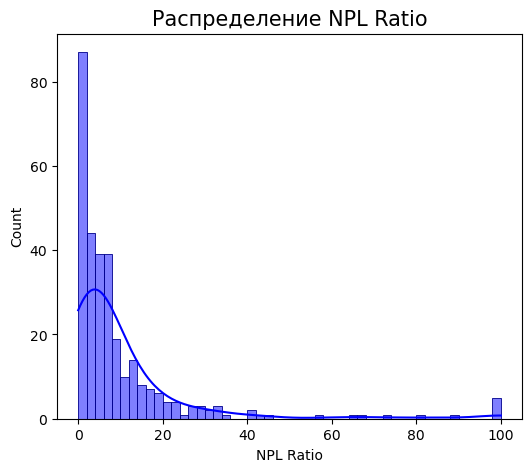

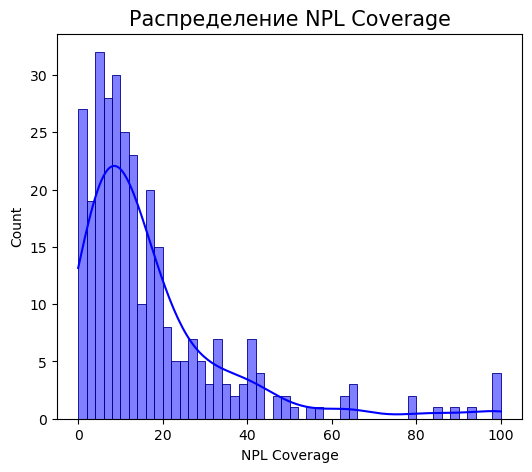

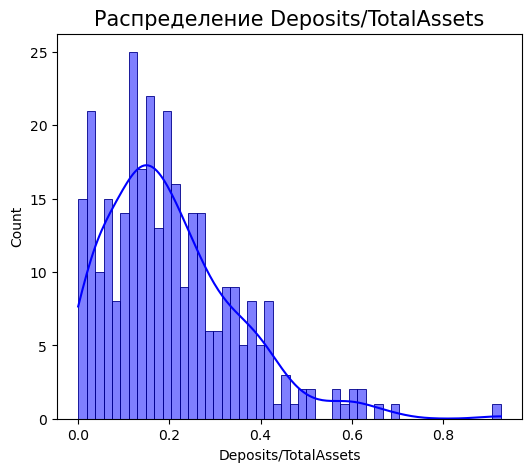

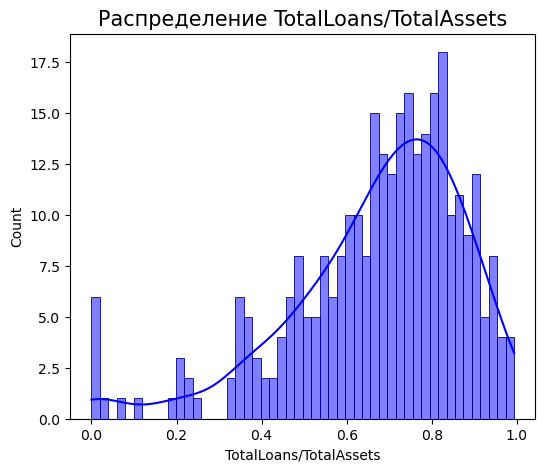

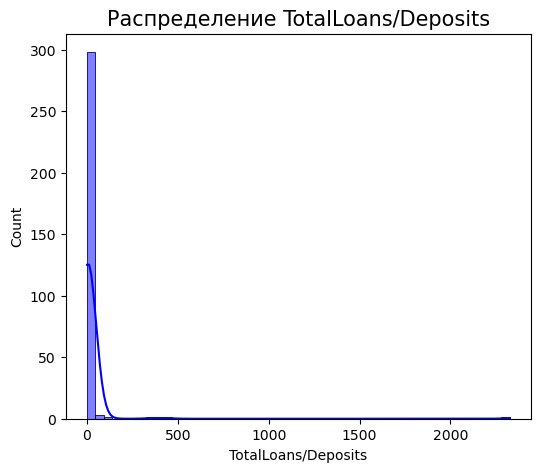

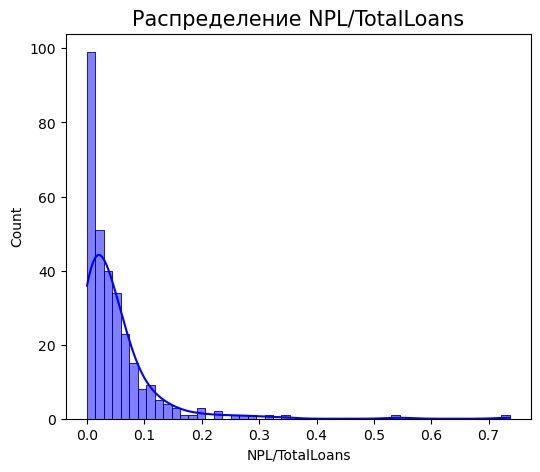

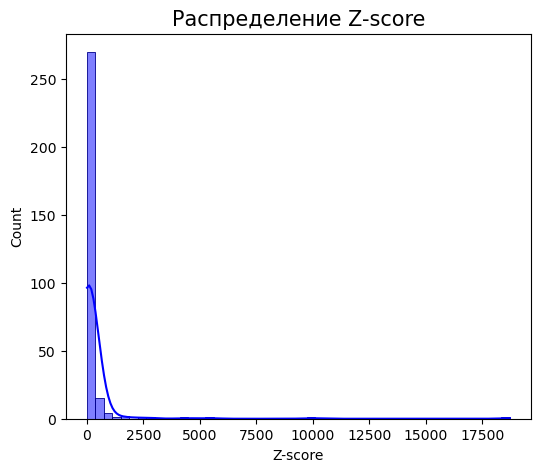

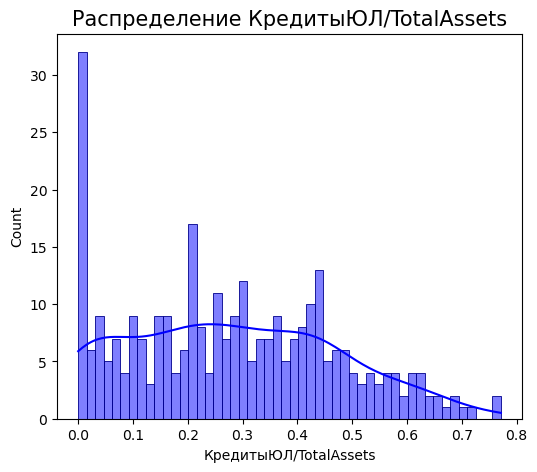

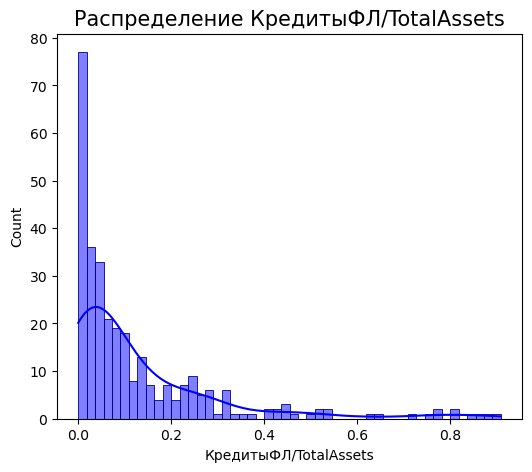

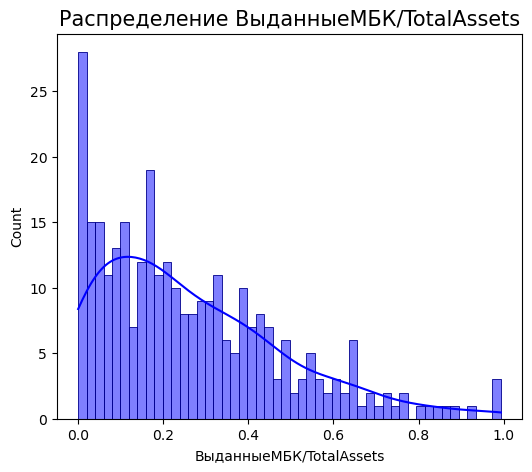

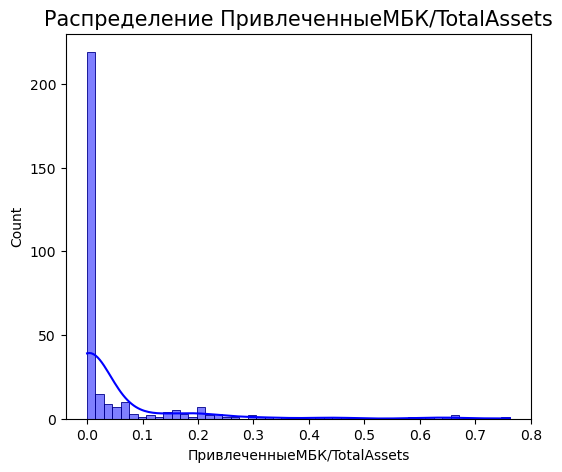

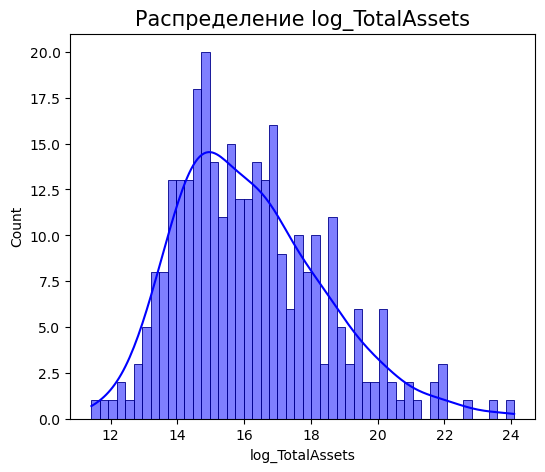

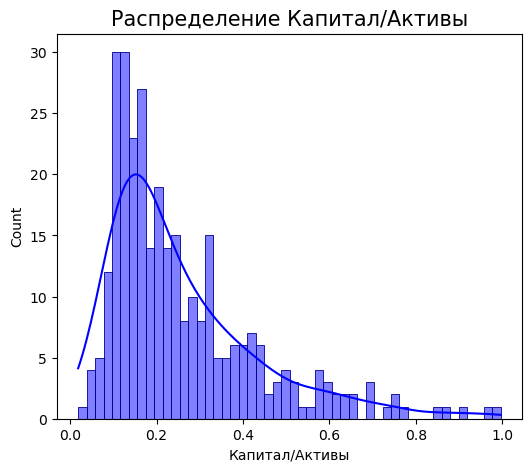

In [70]:
for column in X.columns:
    fig, ax = plt.subplots(figsize=(6, 5))
    ax.set_title(f'Распределение {column}', fontsize=15)
    sns.histplot(X[column],        #np.log1p(X['Z-score']),
                bins=50,
                ax=ax,
                color='blue',
                edgecolor='darkblue',
                kde = True);

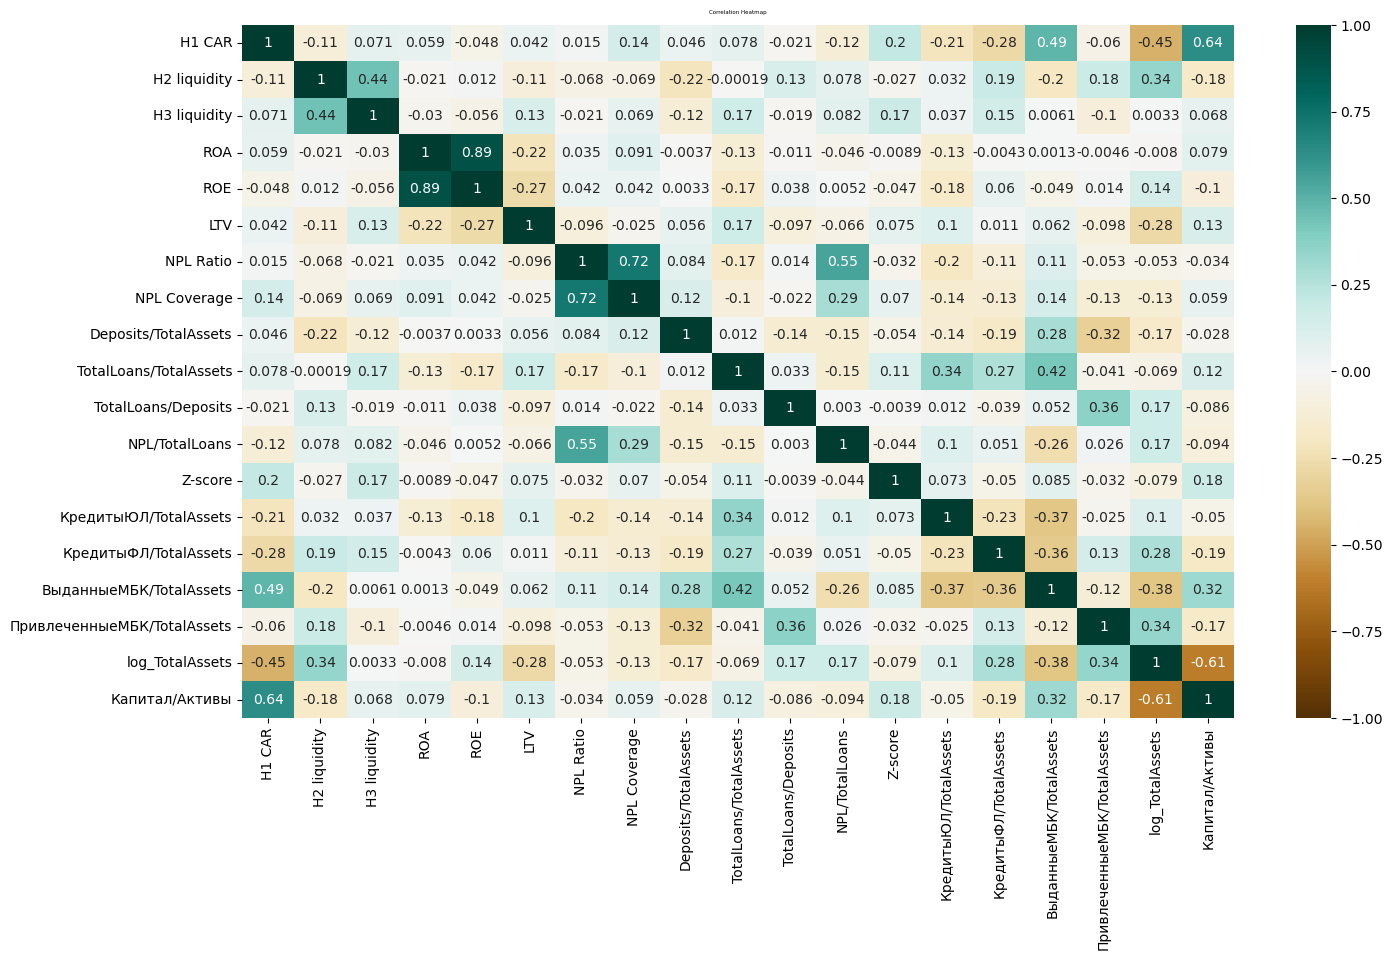

In [74]:
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':4}, pad=8);

### K-means

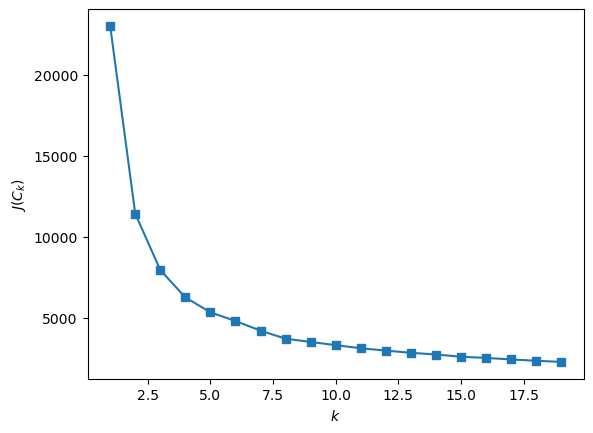

In [76]:
rg = range(1, 20)
inertia = []
for k in rg:
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))
    
plt.plot(rg, inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

Локтя особо не видно - непонятно, сколько брать кластеров

### DBSCAN

In [ ]:
dbscan = DBSCAN(eps=40, min_samples=3)
clustering = dbscan.fit(X)
labels = clustering.labels_
sample_cores=np.zeros_like(labels,dtype=bool)
sample_cores[clustering.core_sample_indices_]=True
n_clusters=len(set(labels))- (1 if -1 in labels else 0)
print('No of clusters:',n_clusters)

In [187]:
# для начала считаем все наблюдения аномальными
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

# берем маленький эпсилон и начинаем увеличивать
eps = 1
eps_history = [eps]

while outlier_percentage > 0.1:    
    model = DBSCAN(eps=eps, min_samples=3).fit(X)
    
    labels = model.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    
    # считаем текущий процент "шума"
    outlier_percentage = sum(labels==1) / len(labels)    
    eps += 1
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)

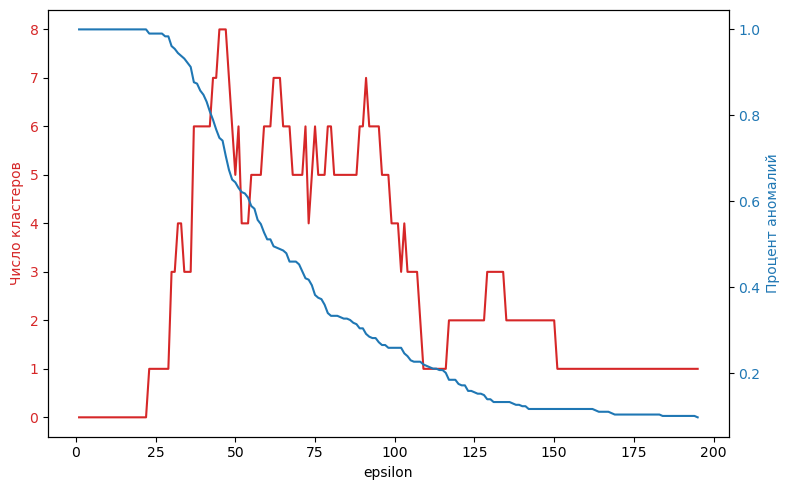

In [188]:
iterations = eps_history[:-1]

fig, ax1 = plt.subplots(figsize=(8,5))
color = 'tab:red'
ax1.set_xlabel('epsilon')
ax1.set_ylabel('Число кластеров', color=color)
ax1.plot(iterations, num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # инициализация второй оси в соотвествии с размером первой

color = 'tab:blue'
ax2.set_ylabel('Процент аномалий', color=color)
ax2.plot(iterations, anomaly_percentage, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()

In [213]:
dbscan = DBSCAN(eps=129, min_samples=3)
clustering = dbscan.fit(X)
labels = clustering.labels_
sample_cores=np.zeros_like(labels,dtype=bool)
sample_cores[clustering.core_sample_indices_]=True
n_clusters=len(set(labels))- (1 if -1 in labels else 0)
print('No of clusters:',n_clusters)

No of clusters: 3


In [214]:
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0, -1,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0, -1,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0, -1,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,
        0, -1,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0,  0,
        0,  0,  0, -1,  0

In [218]:
pca = PCA(n_components=3)
components = pca.fit_transform(X)

total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_3d(
    components, x=0, y=1, z=2, color=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
)
fig.show()

In [219]:
pca = PCA(n_components=2)
components = pca.fit_transform(X)

fig = px.scatter(components, x=0, y=1, color=labels)
fig.show()